<a href="https://colab.research.google.com/github/Legacy560/MLTSA25_RWolynetz/blob/main/Cleaning%20and%20ARIMA/Sales_Forecasting_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pylab as pl
import json
import os
import warnings
import dask.dataframe as dd
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#Data Aquisition

In [ ]:
#!pip install kaggle

In [3]:
from google.colab import drive

drive.mount("/content/gdrive")



Mounted at /content/gdrive


In [4]:
cd /content/gdrive/MyDrive/.Kaggle/

[Errno 2] No such file or directory: '/content/gdrive/MyDrive/.Kaggle/'
/content


In [5]:
cd gdrive/My\ Drive/Graduate School/Graduate Year 2/Spring 2025/My Courses/PHYS 664: Machine Learning for Time Series Analysis/Project/

/content/gdrive/My Drive/Graduate School/Graduate Year 2/Spring 2025/My Courses/PHYS 664: Machine Learning for Time Series Analysis/Project


In [6]:
envs = json.load(open("kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']

In [ ]:
#!kaggle competitions download -c m5-forecasting-accuracy

In [ ]:
#!unzip m5-forecasting-accuracy.zip

#Read in data

In [7]:
cal = pd.read_csv('calendar.csv')
prices = pd.read_csv('sell_prices.csv')
salesVal = pd.read_csv('sales_train_validation.csv')
display(cal.head())
display(salesVal.head())
display(prices.head())

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [8]:
cal.tail()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [9]:
#type of column d in cal
cal.dtypes
#number missing items in cal
cal.isnull().sum()

#number of entries in cal
cal.shape

(1969, 14)

#Reshape sales data into long format.

This allows for us to merge the sales dataset with the calendar dataset. These datasets are large, however; and any operations will cause the Python session to crash. Thus, before we can do anything else, we need to deal with the storage and memory that these datasets take up.

In [8]:
#This code came from: https://www.kaggle.com/competitions/m5-forecasting-accuracy/data. I take no credit for it.

#Downcast in order to save memory
def downcast(df):

  '''
  Changes column types in the dataframe to reduce memory usage.
  Input:
    df (pandas dataframe): dataframe to be downcast.
  Output:
    df (pandas dataframe): dataframe with reduced memory usage.
  '''
  cols = df.dtypes.index.tolist()
  types = df.dtypes.values.tolist()
  for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
  return df

salesVal = downcast(salesVal)
prices = downcast(prices)
cal = downcast(cal)


In [9]:
salesValLong = salesVal.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                         var_name="d", value_name="units_sold").dropna()
#This gives us a column "d" containing each sales day. This is the same as the "d" column from calendar

In [12]:
display(salesVal.head())
display(salesValLong.head(20))
display(cal.head())
display(prices.head())

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


,id,item_id,dept_id,cat_id,store_id,state_id,d,units_sold
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [ ]:
#Get size of these

In [ ]:
#Check for missing values
display(salesValLong.isnull().sum())
display(cal.isnull().sum())
display(prices.isnull().sum())

,0
id,0
item_id,0
dept_id,0
cat_id,0
store_id,0
state_id,0
d,0
units_sold,0


,0
date,0
wm_yr_wk,0
weekday,0
wday,0
month,0
year,0
d,0
event_name_1,1807
event_type_1,1807
event_name_2,1964


,0
store_id,0
item_id,0
wm_yr_wk,0
sell_price,0


#Merging Datasets

In [10]:
#Merge with Calendar dataset
salesValLong1 = salesValLong.merge(cal, on="d", how="left")
display(salesValLong1.head())


,id,item_id,dept_id,cat_id,store_id,state_id,d,units_sold,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


In [11]:
#Merge with prices dataset
salesFull = salesValLong1.merge(prices, on=["store_id", "item_id", "wm_yr_wk"], how="left")


In [12]:

#dump the previous datasets
del salesValLong
del cal
del prices
del salesVal
del salesValLong1


In [15]:
downcast(salesFull) #See if this improves our memory

,id,item_id,dept_id,cat_id,store_id,state_id,d,units_sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58327365,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1913,1,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,2.980469
58327366,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,2.480469
58327367,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,3.980469
58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1913,3,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,1.280273


In [16]:
display(salesFull.columns)

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'units_sold', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

In [17]:
salesFull.shape
#This is a big fucking dataset

(58327370, 22)

Get some statistics

In [18]:
salesFull.describe()

,units_sold,date,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price
count,5.832737e+07,58327370,5.832737e+07,5.832737e+07,5.832737e+07,5.832737e+07,5.832737e+07,5.832737e+07,5.832737e+07,4.602796e+07
mean,1.126322e+00,2013-09-11 00:00:00.000000768,1.133919e+04,3.997386e+00,6.357554e+00,2.013209e+03,3.293257e-01,3.293257e-01,3.293257e-01,NaN
min,0.000000e+00,2011-01-29 00:00:00,1.110100e+04,1.000000e+00,1.000000e+00,2.011000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.000214e-02
25%,0.000000e+00,2012-05-21 00:00:00,1.121700e+04,2.000000e+00,3.000000e+00,2.012000e+03,0.000000e+00,0.000000e+00,0.000000e+00,2.179688e+00
50%,0.000000e+00,2013-09-11 00:00:00,1.133300e+04,4.000000e+00,6.000000e+00,2.013000e+03,0.000000e+00,0.000000e+00,0.000000e+00,3.470703e+00
75%,1.000000e+00,2015-01-02 00:00:00,1.144800e+04,6.000000e+00,9.000000e+00,2.015000e+03,1.000000e+00,1.000000e+00,1.000000e+00,5.839844e+00
max,7.630000e+02,2016-04-24 00:00:00,1.161300e+04,7.000000e+00,1.200000e+01,2.016000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.073125e+02
std,3.873108e+00,NaN,1.503742e+02,2.000652e+00,3.458773e+00,1.532086e+00,4.699684e-01,4.699684e-01,4.699684e-01,0.000000e+00


In [19]:
#Check for missing values in full dataset
display(salesFull.isnull().sum())

#Add total sale column
salesFull['total_sale'] = salesFull['units_sold'] * salesFull['sell_price']

,0
id,0
item_id,0
dept_id,0
cat_id,0
store_id,0
state_id,0
d,0
units_sold,0
date,0
wm_yr_wk,0


#Data Analysis

,total_sale
date,
2011-01-29,36276.601562
2011-01-30,35047.742188
2011-01-31,25283.880859
2011-02-01,26917.210938
2011-02-02,25176.089844


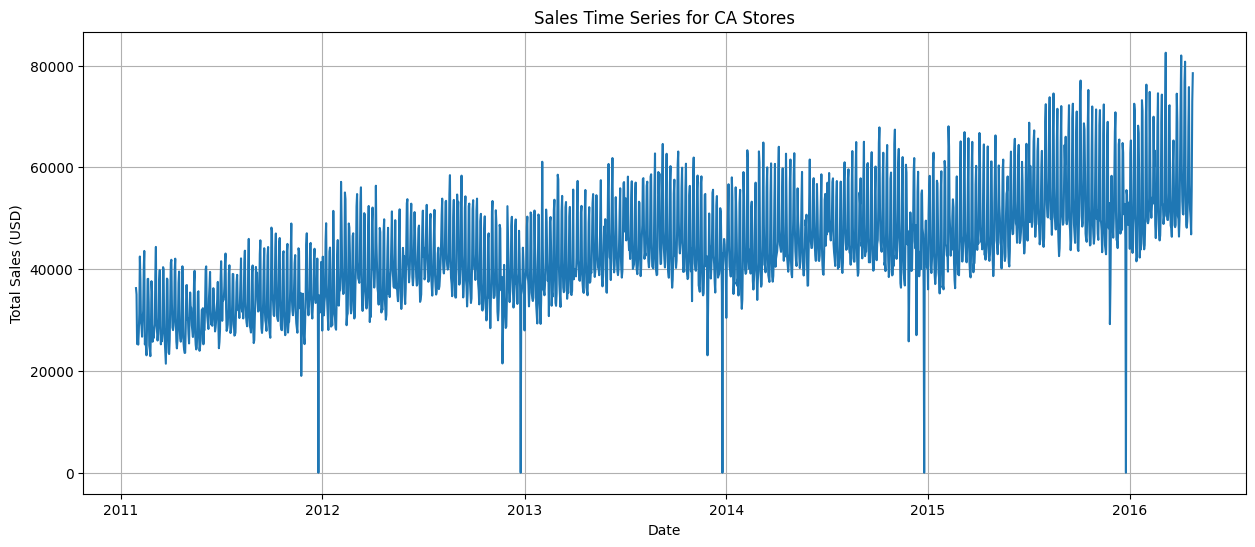

,total_sale
date,
2011-01-29,24100.949219
2011-01-30,23771.890625
2011-01-31,16610.101562
2011-02-01,17958.199219
2011-02-02,14456.099609


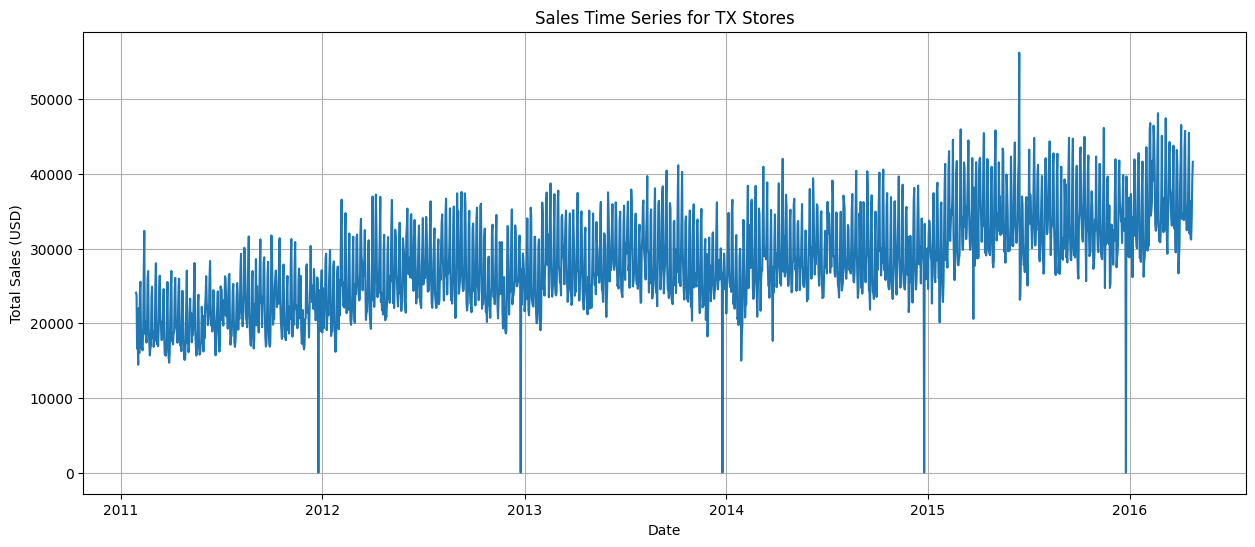

,total_sale
date,
2011-01-29,21274.468750
2011-01-30,20151.740234
2011-01-31,15813.670898
2011-02-01,15886.568359
2011-02-02,7328.752930


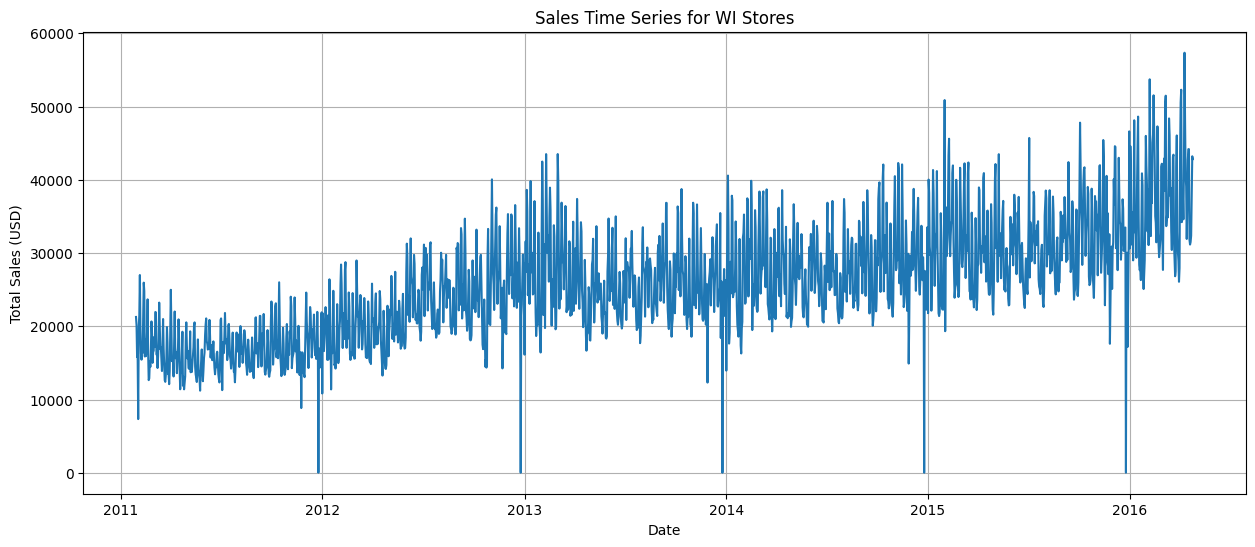

In [44]:
# prompt: I want to plot some times series from salesFull of the sales from all the stores in California over the whole time domain

stateList = salesFull['state_id'].unique()
sales_data = {}  # Create an empty dictionary to store sales data for each state

for i in stateList:

  # Filter for stores
  theSales = salesFull[salesFull['state_id'] == i]

  # Group by date and sum sales
  #change sales_by_date so that it is named for each state

  sales_data[f'sales_by_date{i}'] = theSales.groupby('date')['total_sale'].sum()
  display(sales_data[f'sales_by_date{i}'].head())
  # Plot the time series
  plt.figure(figsize=(15, 6))
  plt.plot(sales_data[f'sales_by_date{i}'].index, sales_data[f'sales_by_date{i}'].values)  # Plot using the new variable name

  plt.xlabel('Date')
  plt.ylabel('Total Sales (USD)')
  plt.title(f'Sales Time Series for {i} Stores')
  plt.grid(True)
  plt.show()


Those regular low values are all from Christmas Day. Walmart is usually closed around this time. Perhaps a few stores were open for a few hours over this time period. Otherwise, there is definite seasonality with an overall upward trend.

In [22]:
#Figure out what those low values are. It's Christmas
display(sales_data['sales_by_dateCA'].sort_values(ascending=True).head(10))
display(sales_data['sales_by_dateTX'].sort_values(ascending=True).head(10))
display(sales_data['sales_by_dateWI'].sort_values(ascending=True).head(20))

,total_sale
date,
2014-12-25,10.178711
2011-12-25,10.882324
2013-12-25,11.501953
2015-12-25,11.520508
2012-12-25,13.529785
2011-11-24,19033.308594
2011-03-24,21426.302734
2012-11-22,21478.867188
2011-02-24,22904.308594


,total_sale
date,
2011-12-25,3.360352
2012-12-25,5.259766
2015-12-25,12.759766
2013-12-25,20.242188
2014-12-25,24.998535
2011-02-02,14456.099609
2011-03-30,14726.674805
2014-01-28,15004.984375
2011-04-27,15099.568359


,total_sale
date,
2013-12-25,2.580078
2014-12-25,2.679688
2012-12-25,5.939453
2015-12-25,6.509766
2011-12-25,9.441406
2011-02-02,7328.752930
2011-11-24,8834.998047
2012-01-01,10822.994141
2011-05-25,11208.576172


##Data Cleaning

We will now clean our data a bit before fitting an ARIMA model to it.

In [25]:
sales_data['sales_by_dateCA'].head()

,total_sale
date,
2011-01-29,36276.601562
2011-01-30,35047.742188
2011-01-31,25283.880859
2011-02-01,26917.210938
2011-02-02,25176.089844


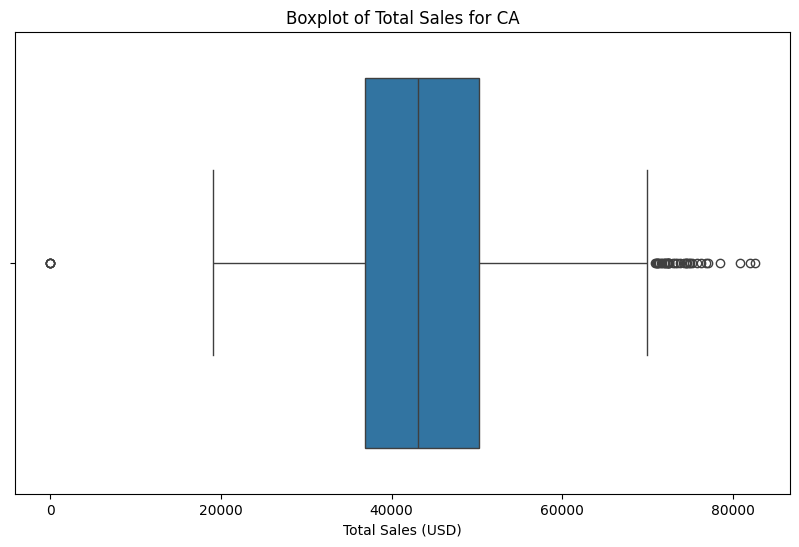

Potential outliers for CA:
date
2011-12-25       10.882324
2012-12-25       13.529785
2013-12-25       11.501953
2014-12-25       10.178711
2015-08-02    72408.007812
2015-08-09    73776.929688
2015-08-16    74514.921875
2015-08-23    71507.742188
2015-08-30    72038.218750
2015-09-13    72212.890625
2015-09-20    72506.914062
2015-09-27    70969.937500
2015-10-03    74903.367188
2015-10-04    77051.523438
2015-10-18    75201.671875
2015-10-25    71959.328125
2015-11-01    71375.273438
2015-11-08    71249.898438
2015-11-15    72359.875000
2015-12-06    70812.632812
2015-12-25       11.520508
2016-01-09    72495.632812
2016-01-10    71077.734375
2016-01-23    73196.265625
2016-01-24    71126.078125
2016-01-31    76247.648438
2016-02-06    74823.468750
2016-02-21    74551.281250
2016-02-28    74294.523438
2016-03-05    71615.804688
2016-03-06    82518.234375
2016-03-12    72018.906250
2016-03-13    72199.164062
2016-03-26    74473.710938
2016-04-02    73376.406250
2016-04-03    81978.523

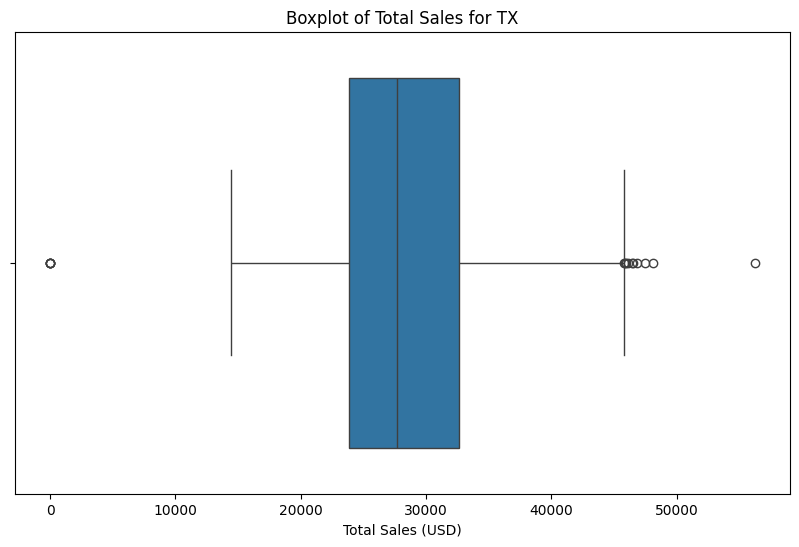

Potential outliers for TX:
date
2011-12-25        3.360352
2012-12-25        5.259766
2013-12-25       20.242188
2014-12-25       24.998535
2015-03-01    45951.949219
2015-05-03    45817.292969
2015-06-15    56207.746094
2015-11-15    46143.714844
2015-12-25       12.759766
2016-02-06    45890.265625
2016-02-07    46790.238281
2016-02-13    46448.636719
2016-02-21    48116.582031
2016-03-06    47439.472656
2016-04-03    46542.691406
Name: total_sale, dtype: float32
--------------------


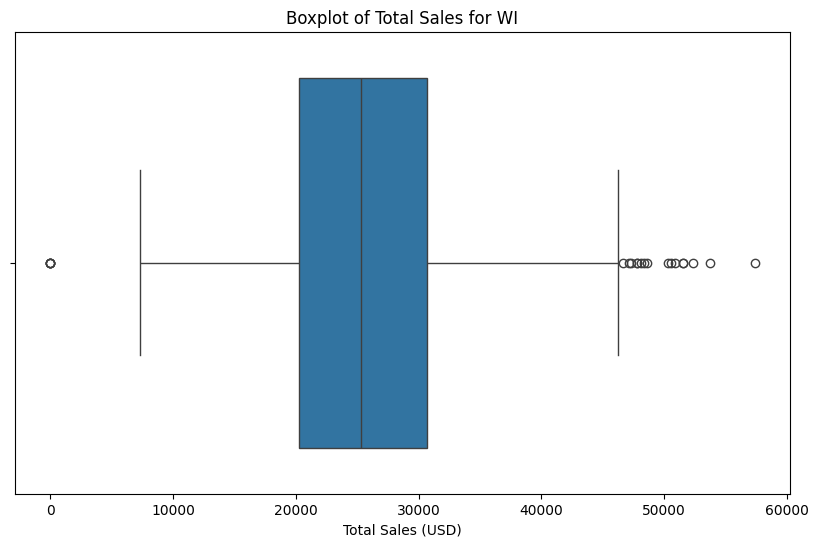

Potential outliers for WI:
date
2011-12-25        9.441406
2012-12-25        5.939453
2013-12-25        2.580078
2014-12-25        2.679688
2015-01-31    50893.859375
2015-10-03    47806.894531
2015-12-25        6.509766
2015-12-31    46618.433594
2016-01-09    48132.652344
2016-01-16    48634.566406
2016-02-06    53726.546875
2016-02-13    51541.621094
2016-02-14    47098.195312
2016-02-20    47299.785156
2016-03-05    50341.109375
2016-03-06    51489.746094
2016-03-12    48385.035156
2016-04-02    50560.582031
2016-04-03    52303.343750
2016-04-09    57358.941406
2016-04-10    47817.488281
Name: total_sale, dtype: float32
--------------------


In [23]:
# prompt: Check the datasets for outliers

import matplotlib.pyplot as plt
# Check for outliers using boxplots for each state's sales data
for state in stateList:
    sales_series = sales_data[f'sales_by_date{state}']
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=sales_series.values)
    plt.title(f'Boxplot of Total Sales for {state}')
    plt.xlabel('Total Sales (USD)')
    plt.show()

    # Identify potential outliers using IQR
    Q1 = sales_series.quantile(0.25)
    Q3 = sales_series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = sales_series[(sales_series < lower_bound) | (sales_series > upper_bound)]
    print(f"Potential outliers for {state}:")
    print(outliers)
    print("-" * 20)

#Further analysis of outliers:
#1. Investigate the dates corresponding to outliers. Are there any special events or holidays?
#2. Consider the context of the data. Are the outliers truly errors or do they represent legitimate extreme values?
#3. Decide on a strategy for handling outliers (removal, transformation, or capping)
#4. Visualize the data after outlier handling to confirm its effect.


This cell below checks if our data is stationary using the AD Fuller test. Run it after applying transformations to check for stationarity.

In [45]:
#Make 3 dfs for the total sales
salesCA = pd.DataFrame(sales_data['sales_by_dateCA'])
salesTX = pd.DataFrame(sales_data['sales_by_dateTX'])
salesWI = pd.DataFrame(sales_data['sales_by_dateWI'])

#Release sales_data
del sales_data

In [62]:
#Check our datasets for stationarity
#We will use the ADF test to do this

def adfuller_test(sales_series):
    result=adfuller(sales_series)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
          print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
          print("Weak evidence against null hypothesis. Data is not stationary.")
    print("================================")
    print("================================")


adfuller_test(salesCA)
adfuller_test(salesTX)
adfuller_test(salesWI)



ADF Test Statistic : -0.8387244986264757
p-value : 0.8074816245561093
#Lags Used : 26
Number of Observations Used : 1881
Weak evidence against null hypothesis. Data is not stationary.
ADF Test Statistic : -1.3832865986167064
p-value : 0.5902619894162894
#Lags Used : 26
Number of Observations Used : 1881
Weak evidence against null hypothesis. Data is not stationary.
ADF Test Statistic : -0.6884873017293948
p-value : 0.8497090918808816
#Lags Used : 26
Number of Observations Used : 1881
Weak evidence against null hypothesis. Data is not stationary.


In [53]:
#Get rid of the Christmas.
yearList = salesFull['year'].unique()
yearList = np.delete(yearList, -1)
print(yearList)
'''
for i in yearList:
  #remove only christmas day
  salesCA.drop(f"{i}-12-25", axis = 0, inplace = True)
  salesTX.drop(f"{i}-12-25", axis = 0, inplace = True)
  salesWI.drop(f"{i}-12-25", axis = 0, inplace = True)
  '''


display(salesCA.sort_values(by = "total_sale", ascending=True).head(5))
display(salesTX.sort_values(by = "total_sale", ascending=True).head(5))
display(salesWI.sort_values(by = "total_sale", ascending=True).head(5))


[2011 2012 2013 2014 2015]


,total_sale
date,
2011-11-24,19033.308594
2011-03-24,21426.302734
2012-11-22,21478.867188
2011-02-24,22904.308594
2013-11-28,23078.205078


,total_sale
date,
2011-02-02,14456.099609
2011-03-30,14726.674805
2014-01-28,15004.984375
2011-04-27,15099.568359
2011-04-26,15201.435547


,total_sale
date,
2011-02-02,7328.752930
2011-11-24,8834.998047
2012-01-01,10822.994141
2011-05-25,11208.576172
2011-07-04,11282.075195


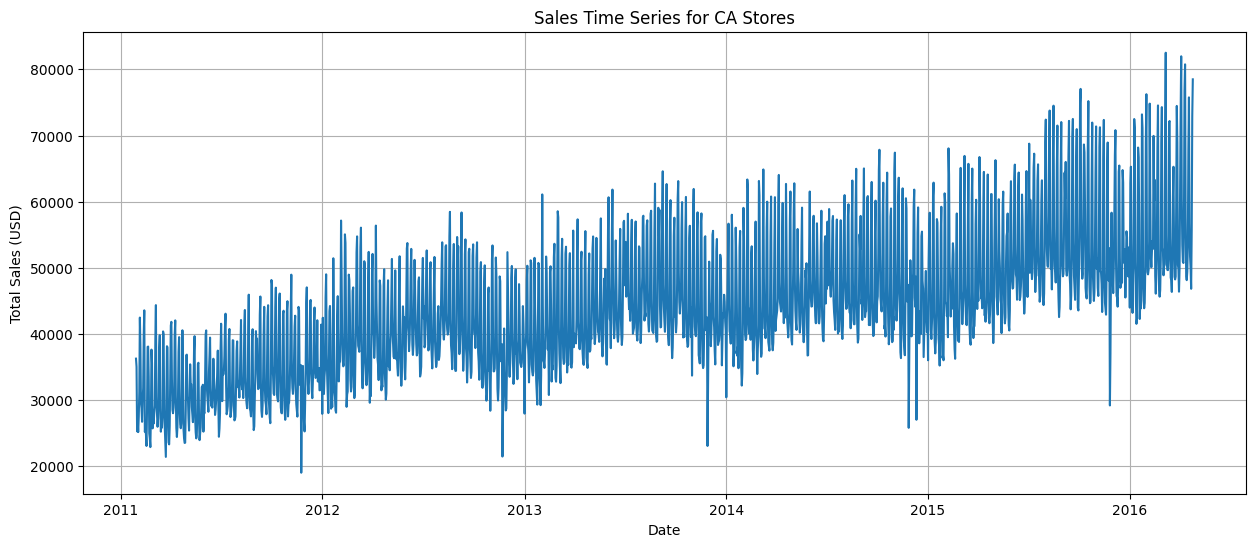

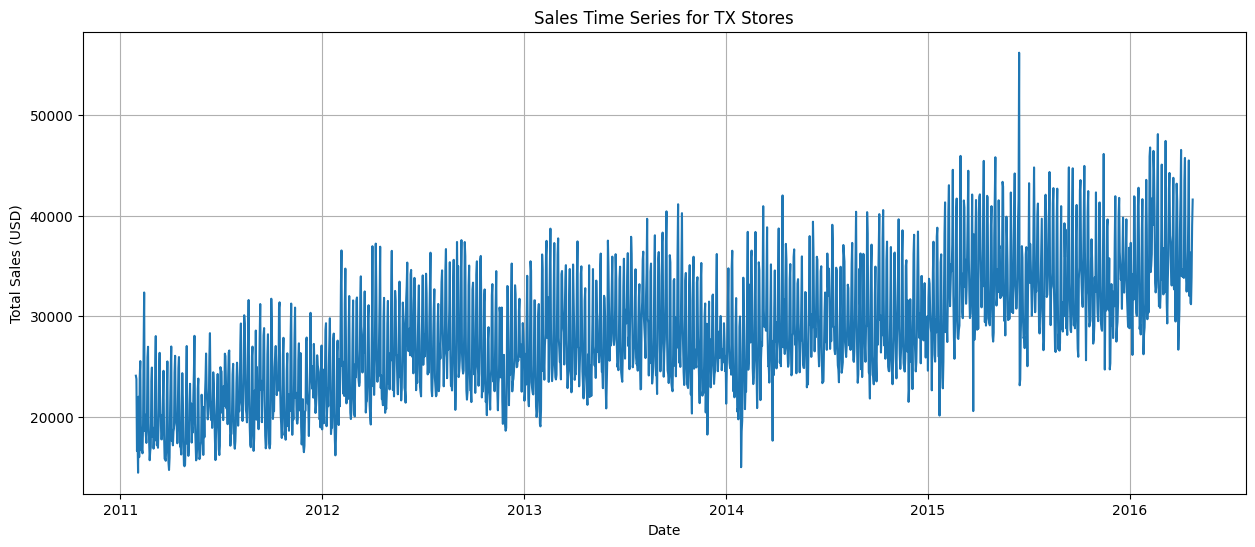

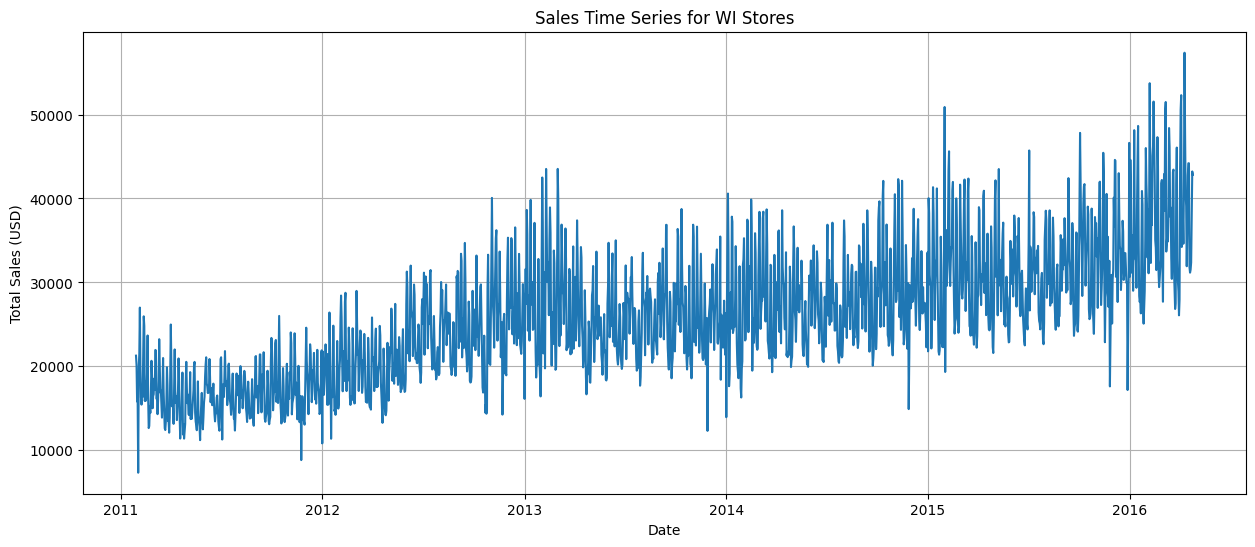

In [61]:
# plot again
salesList = [salesCA, salesTX, salesWI]

  # Create an empty dictionary to store sales data for each state

for index, i in enumerate(salesList):
  plt.figure(figsize=(15, 6))
  plot(i.index, i["total_sale"])

  plt.xlabel('Date')
  plt.ylabel('Total Sales (USD)')
  plt.title(f'Sales Time Series for {stateList[index]} Stores')
  plt.grid(True)
  plt.show()


In [50]:
#Get column names
type(salesCA.index.name)
salesCA.head()

,total_sale
date,
2011-01-29,36276.601562
2011-01-30,35047.742188
2011-01-31,25283.880859
2011-02-01,26917.210938
2011-02-02,25176.089844
